# A Deep Dive into the S&P 500: Predicting Stock Prices
Kanishk Chinnapapannagari, Aarav Naveen, Avyay Potarlanka, and Melvin Rajendran

## Introduction

In today’s evolving financial landscape, both investors and traders are constantly seeking an edge to make informed decisions. The stock market, which contains an intricate web of variables and is influenced by numerous factors, has proven to be a difficult environment to navigate.

In the past, investment-related decisions were often made based on analysis of historical trends. However, the advancement of data science and machine learning techniques has introduced a new opportunity to potentially predict future stock prices with reasonable accuracy and thus gain valuable insights.

This data science project delves into prediction of stock prices within the Standard & Poor’s 500 index, otherwise known as the S&P 500. This index contains 500 of the top companies in the United States, and it represents approximately 80% of the U.S. stock market’s total value. Hence, it serves as a strong indicator of the movement within the market. To learn more about the S&P 500 and other popular indices in the U.S., read this article: https://www.investopedia.com/insights/introduction-to-stock-market-indices/.

Throughout this project, we will follow a comprehensive data science approach that includes the following steps:
* Data collection
* Data processing
* Exploratory data analysis and data visualization
* Data analysis, hypothesis testing, and machine learning (ML)
* Insight formation

Our project aims to leverage predictive modeling techniques to provide insights to investors. The analysis herein will identify stocks that are undervalued and thus will increase in price in the near future, meaning investors should consider buying or holding shares. Likewise, it will also identify stocks that are overvalued and will soon decrease in price, indicating that investors should consider selling their position.

In [1]:
# Import necessary libraries
from bs4 import BeautifulSoup
import numpy as np
import os
import pandas as pd
import requests
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## Data Collection

### Reading in a Kaggle Dataset

To gather information about the S&P 500 companies, we will be using the following dataset: https://www.kaggle.com/datasets/paultimothymooney/stock-market-data. This Kaggle dataset contains the date, volume, and prices for the NASDAQ, NYSE, and S&P 500. For the purposes of this project, we will only analyze the stock prices of companies in the S&P 500.

In [2]:
# Initialize an empty data frame to store the stock price data
price_data = pd.DataFrame()

# Initialize the path to the folder containing the data
folder_path = 'sp500-data'

# Iterate across each file in the folder by name
for file_name in os.listdir(folder_path):
    
    # Check if the current file is a CSV file
    if file_name.endswith('.csv'):
        
        # Read the current file into a temporary data frame
        temp = pd.read_csv(os.path.join(folder_path, file_name))
        
        # Extract the symbol from the current file's name
        symbol = file_name[0:-4]
        
        # Store the symbol in a new column in the temporary data frame 
        temp['Symbol'] = symbol
        
        # Concatenate the accumulating and temporary data frames
        price_data = pd.concat([price_data, temp], ignore_index = True)

# Print the last five rows of the price data frame
price_data.tail()

,Date,Low,Open,Volume,High,Close,Adjusted Close,Symbol
3265995,06-12-2022,152.089996,154.220001,1964800.0,155.500000,153.050003,153.050003,ZTS
3265996,07-12-2022,149.380005,152.960007,2444100.0,153.789993,150.250000,150.250000,ZTS
3265997,08-12-2022,149.199997,150.529999,2267500.0,154.350006,153.679993,153.679993,ZTS
3265998,09-12-2022,152.740005,153.940002,3274900.0,156.330002,153.389999,153.389999,ZTS
3265999,12-12-2022,152.970001,154.070007,301135.0,154.470001,153.625000,153.625000,ZTS


### Webscraping From Wikipedia

We noticed that the Kaggle dataset does not contain sector data. For this reason, we will supplement our existing data with that which is contained on the following webpage: https://en.wikipedia.org/wiki/List_of_S%26P_500_companies. By scraping this webpage's list of the S&P 500 companies, we can match each company in our existing data to its corresponding GICS sector and sub-industry. This will enable us to perform analysis by sector and/or sub-industry and thus eliminate biases in our modeling.

In [3]:
# Headers for the HTTP request
headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
    'From': 'pleaseletmein@gmail.com'
}

# Make an HTTP request to the Wikipedia URL and store the response
response = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', headers = headers)

# Parse the text from the webpage as HTML
soup = BeautifulSoup(response.text, 'html.parser')

# Find the table element containing the data and both extract and store the data
table = soup.find('table')

# Read the HTML table into a data frame
sector_data = pd.read_html(str(table), flavor = 'html5lib')[0]

# Print the last five rows of the sector data frame
sector_data.tail()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873
502,ZTS,Zoetis,Health Care,Pharmaceuticals,"Parsippany, New Jersey",2013-06-21,1555280,1952


### Webscraping From Slickcharts

We would also like to focus our attention on the top 10 companies of each sector, as these companies drive the movement within their respective sectors. Hence, we will scrape the data from the following webpage: https://www.slickcharts.com/sp500. This webpage contains a list of the S&P 500 companies by weight, where weight is equal to a company's market cap divided by the overall value of the S&P 500. Ultimately, we will select the top 10 companies of each sector by weight.

In [4]:
# Make an HTTP request to the Slickcharts URL and store the response
response = requests.get('https://www.slickcharts.com/sp500', headers = headers)

# Parse the text from the webpage as HTML
soup = BeautifulSoup(response.text, 'html.parser')

# Find the table element containing the data and both extract and store the data
table = soup.find('table')

# Read the HTML table into a data frame
weight_data = pd.read_html(str(table), flavor = 'html5lib')[0]

# Print the last five rows of the sector data frame
weight_data.tail()

,#,Company,Symbol,Weight,Price,Chg,% Chg
498,499,Newell Brands Inc,NWL,0.010325,9.26,-0.25,(-2.58%)
499,500,Zions Bancorporation N.A.,ZION,0.009851,22.18,-0.50,(-2.20%)
500,501,Lincoln National Corp,LNC,0.008901,19.09,-0.85,(-4.26%)
501,502,News Corporation Class B,NWS,0.005934,17.99,1.16,(6.86%)
502,503,DISH Network Corporation Class A,DISH,0.004431,6.13,-0.11,(-1.69%)


## Data Processing

We will merge the data collected in the previous step into a single data frame. Then, we will filter our data to include only the top 5 companies within each sector. As part of this process, we need to caste our data to the proper types, remove entries with missing values, and remove unnecessary columns.

### Cleaning the Sector Data

In [5]:
# Rename the sector and industry-related columns
sector_data = sector_data.rename(columns = {'GICS Sector': 'Sector', 'GICS Sub-Industry': 'Industry'})

# Drop unnecessary columns
sector_data = sector_data.drop(['Headquarters Location', 'Date added', 'CIK', 'Founded'], axis = 1)

# Print the last five rows of the data frame
sector_data.tail()

,Symbol,Security,Sector,Industry
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment
501,ZION,Zions Bancorporation,Financials,Regional Banks
502,ZTS,Zoetis,Health Care,Pharmaceuticals


### Cleaning the Weight Data

In [6]:
# Drop all columns except Symbol and Weight
weight_data = weight_data.drop(['#', 'Company', 'Price', 'Chg', '% Chg'], axis = 1)

# Print the last five rows of the data frame
weight_data.tail()

,Symbol,Weight
498,NWL,0.010325
499,ZION,0.009851
500,LNC,0.008901
501,NWS,0.005934
502,DISH,0.004431


### Merging the Three Data Frames

In [7]:
# Perform an inner join (merge) on all three data frames to create a single data frame
data = pd.merge(pd.merge(price_data, sector_data, on = 'Symbol'), weight_data, on = 'Symbol')

# Reindex the columns of the data frame
data = data.reindex(columns = ['Symbol', 'Security', 'Sector', 'Industry', 'Weight', 'Date', 'Open', 'High', 'Low', 'Close', 'Adjusted Close', 'Volume'])

# Cast the Date column's type to datetime
data['Date'] = pd.to_datetime(data['Date'], dayfirst = True)

# Print the last five rows of the resulting data frame
data.tail()

,Symbol,Security,Sector,Industry,Weight,Date,Open,High,Low,Close,Adjusted Close,Volume
2890656,ZTS,Zoetis,Health Care,Pharmaceuticals,0.249449,2022-12-06,154.220001,155.500000,152.089996,153.050003,153.050003,1964800.0
2890657,ZTS,Zoetis,Health Care,Pharmaceuticals,0.249449,2022-12-07,152.960007,153.789993,149.380005,150.250000,150.250000,2444100.0
2890658,ZTS,Zoetis,Health Care,Pharmaceuticals,0.249449,2022-12-08,150.529999,154.350006,149.199997,153.679993,153.679993,2267500.0
2890659,ZTS,Zoetis,Health Care,Pharmaceuticals,0.249449,2022-12-09,153.940002,156.330002,152.740005,153.389999,153.389999,3274900.0
2890660,ZTS,Zoetis,Health Care,Pharmaceuticals,0.249449,2022-12-12,154.070007,154.470001,152.970001,153.625000,153.625000,301135.0


### Filtering the Top 5 Companies Within Each Sector

In [8]:
# Initialize an empty data frame to contain the filtered data
top_data = pd.DataFrame()

# Iterate across a list of the unique sectors
for sector in data['Sector'].unique():
    
    # Filter the data by the current sector
    sector_data = data[data['Sector'] == sector]

    # Compile a list of the top five weights in the current sector
    top_five_weights = sorted(sector_data['Weight'].unique(), reverse = True)[:5]
    
    # Filter the data by the top five weights
    sector_data = sector_data[sector_data['Weight'].isin(top_five_weights)]
    
    # Concatenate the top five companies' data into the accumulating dataframe
    top_data = pd.concat([top_data, sector_data], ignore_index = True)

# Print the last five rows of the filtered data frame
top_data.tail()

,Symbol,Security,Sector,Industry,Weight,Date,Open,High,Low,Close,Adjusted Close,Volume
518500,VZ,Verizon,Communication Services,Integrated Telecommunication Services,0.457305,2022-12-06,36.990002,37.070000,36.630001,36.889999,36.889999,26293700.0
518501,VZ,Verizon,Communication Services,Integrated Telecommunication Services,0.457305,2022-12-07,36.740002,37.310001,36.669998,37.169998,37.169998,23065900.0
518502,VZ,Verizon,Communication Services,Integrated Telecommunication Services,0.457305,2022-12-08,37.110001,37.240002,36.869999,37.099998,37.099998,19549100.0
518503,VZ,Verizon,Communication Services,Integrated Telecommunication Services,0.457305,2022-12-09,37.209999,37.630001,36.959999,37.400002,37.400002,20669100.0
518504,VZ,Verizon,Communication Services,Integrated Telecommunication Services,0.457305,2022-12-12,37.689999,37.730000,37.279999,37.615002,37.615002,4698435.0


## Exploratory Data Analysis and Data Visualization

Before we fit a machine learning model to our data, we would like to visualize it by sector and preliminarily determine relationships between the data. In particular, we would like to analyze how strongly the stock prices of companies within the same sector are correlated.

For the remainder of our analysis, we will focus our attention on adjusted close price, which is the final price at which a security  trades at the end of a trading day, adjusting for dividends, stock splits, and new offerings. It is the most accurate representation of a company's stock price, and it is commonly used by investors and traders to track performance.

### Plotting Adjusted Close Price vs. Date

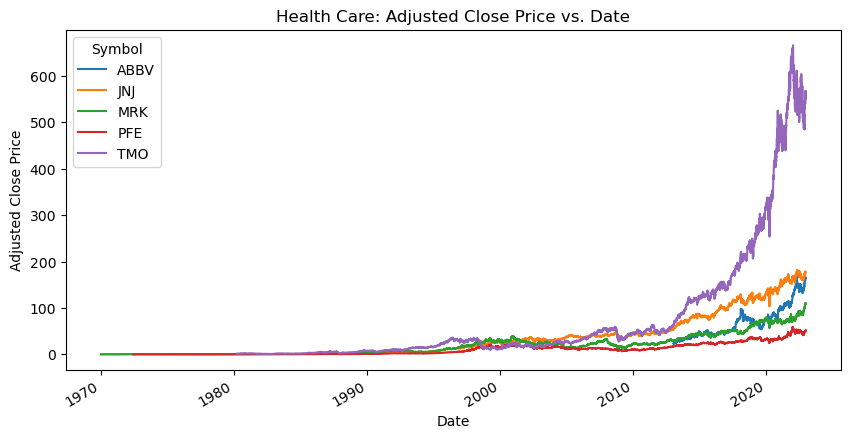

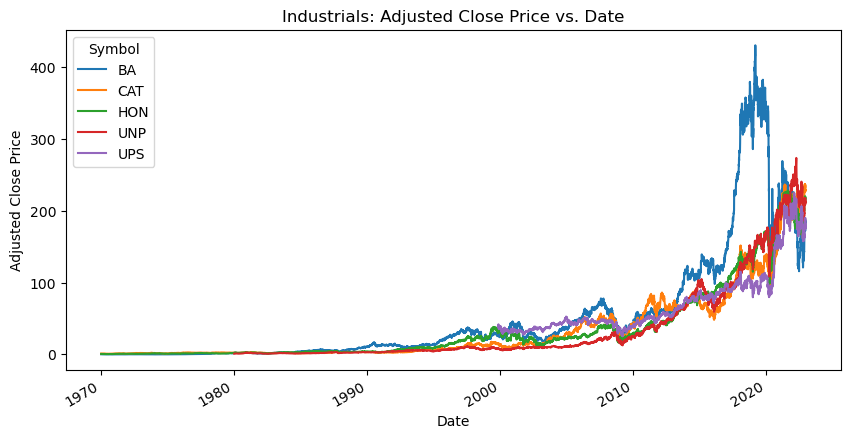

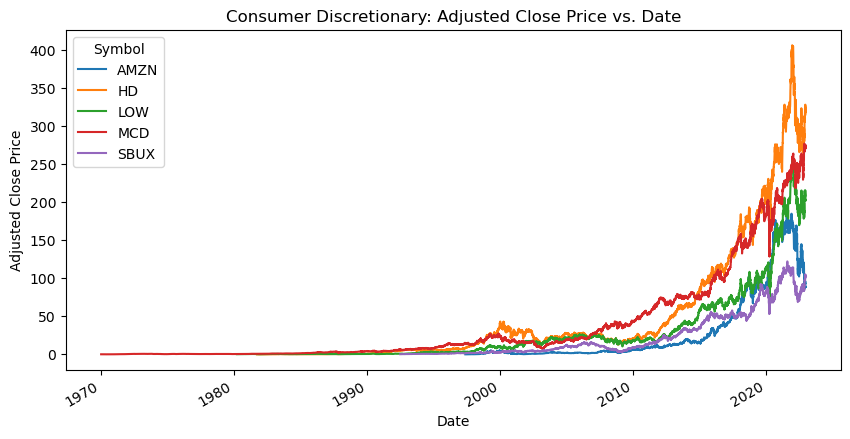

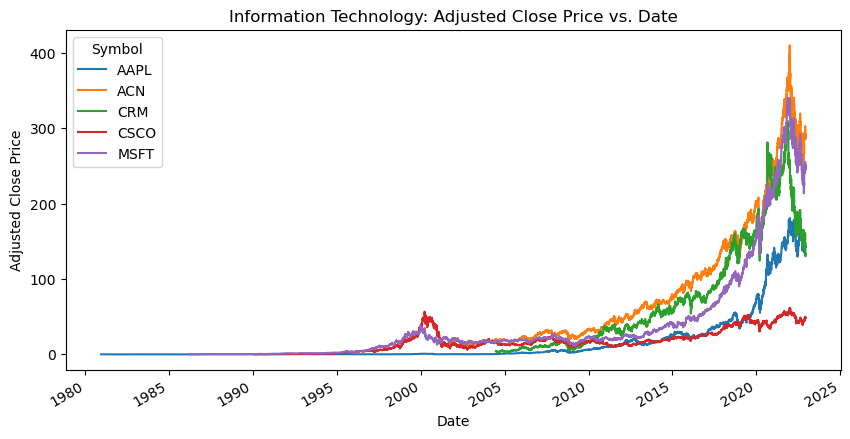

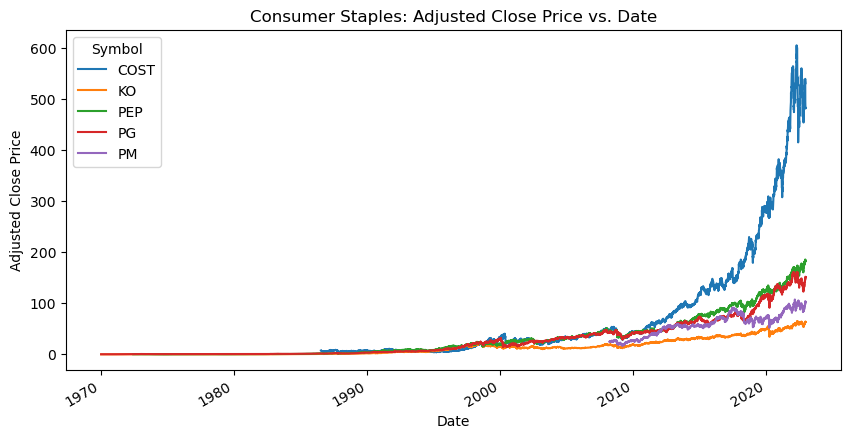

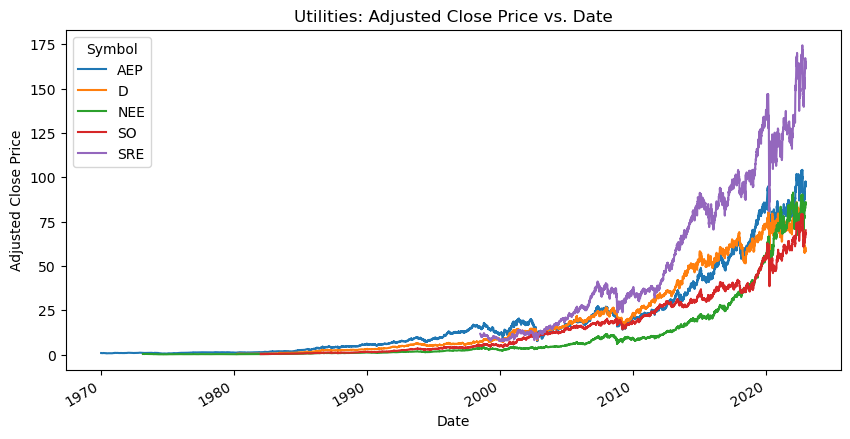

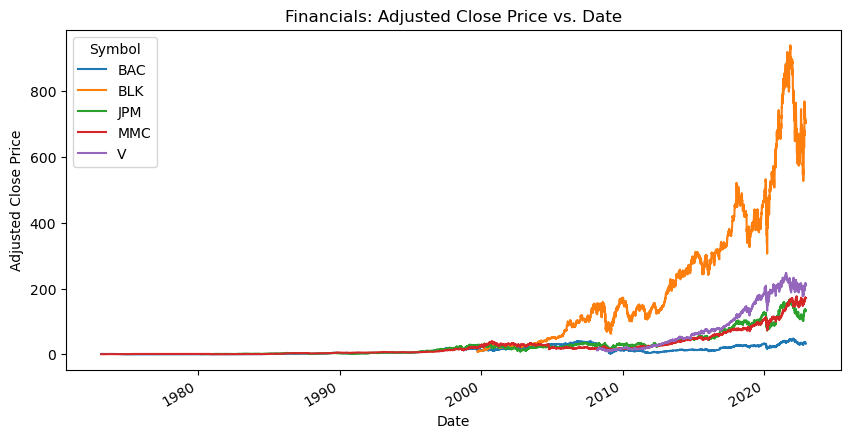

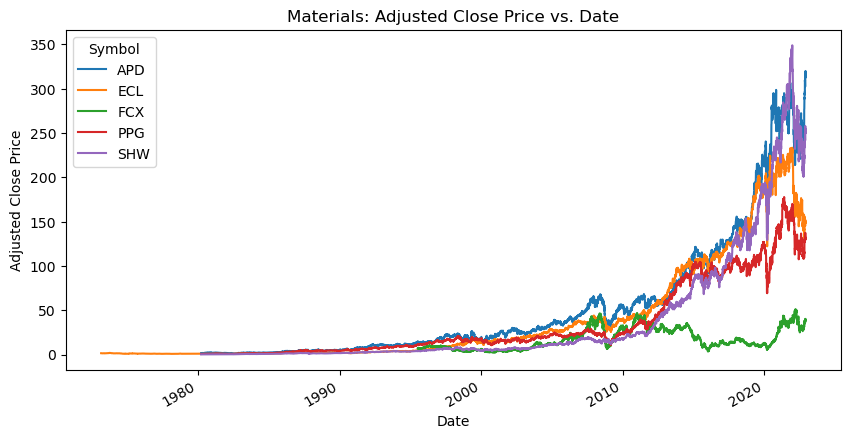

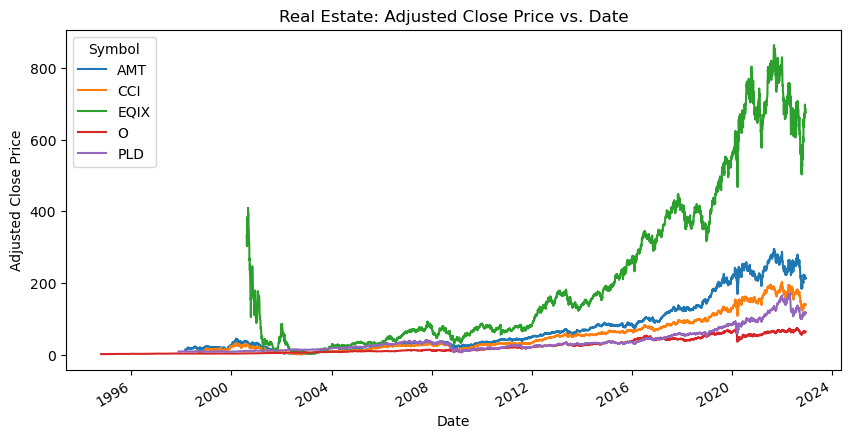

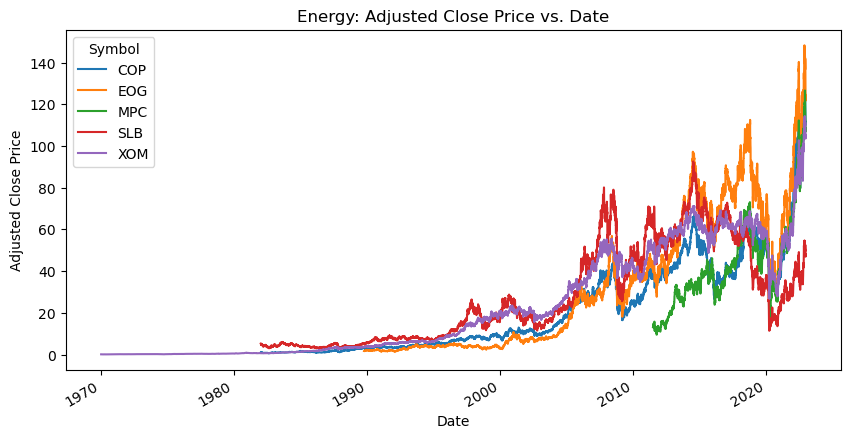

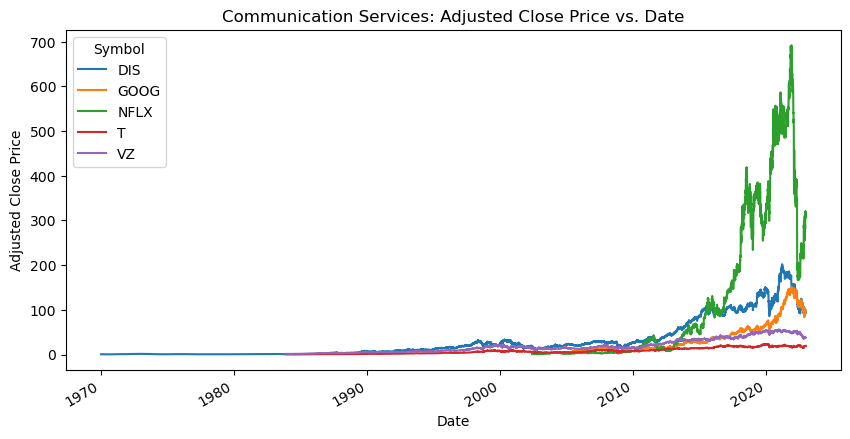

In [9]:
# Generate a plot for the top five companies in each sector
for sector in top_data['Sector'].unique():
    
    # Filter the data for the current sector
    sector_data = top_data[top_data['Sector'] == sector]
    
    # Reshape the data for plotting purposes
    sec_as_row = sector_data.pivot(index = 'Date', columns = 'Symbol', values = 'Adjusted Close')
    
    # Generate plot
    sec_as_row.plot(title = f'{sector}: Adjusted Close Price vs. Date', legend = True, xlabel = 'Date', ylabel = 'Adjusted Close Price', figsize = (10, 5))

Above are 11 line plots of adjusted close price vs. date for the the top five companies (by weight) in each sector.

ANALYZE CORRELATIONS

### Plotting Volume vs. Date

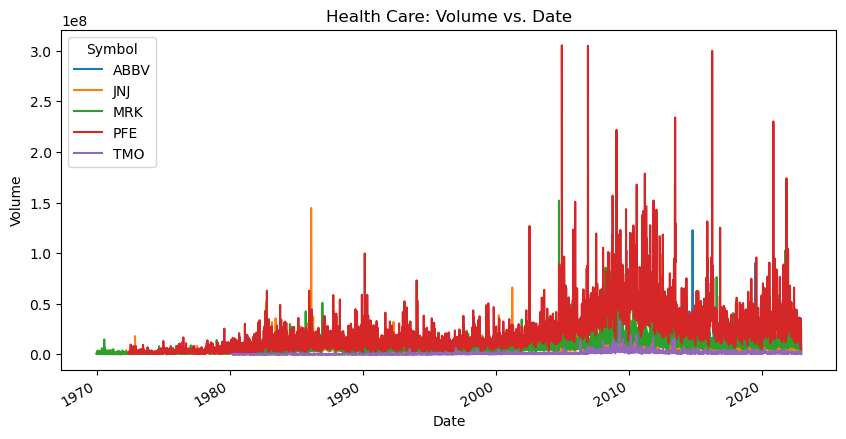

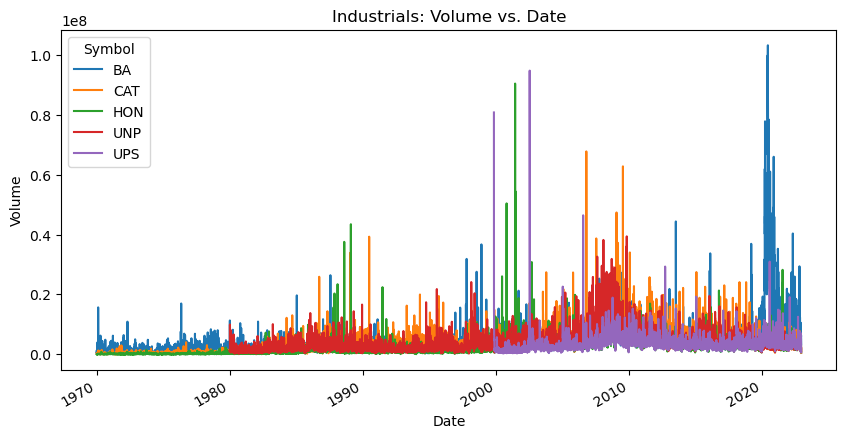

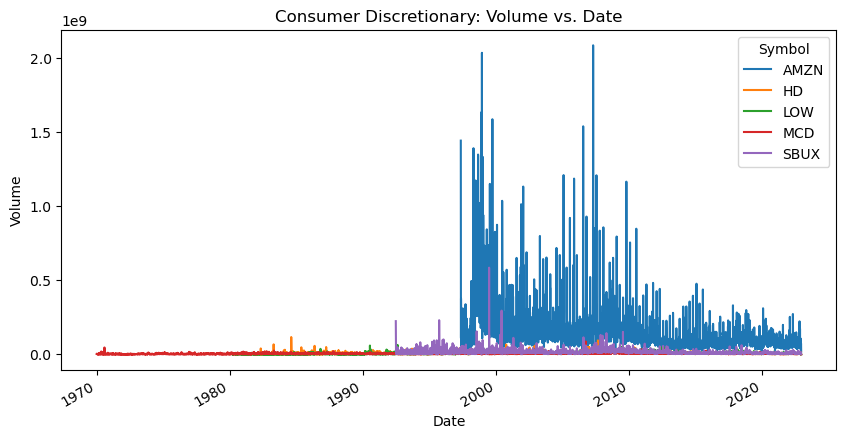

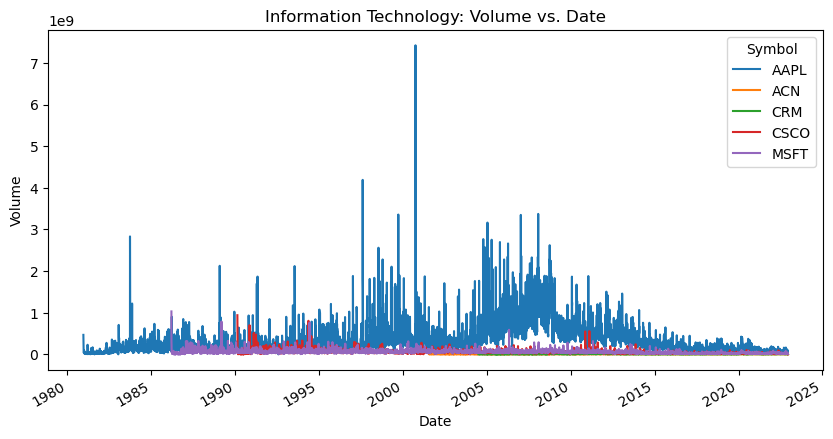

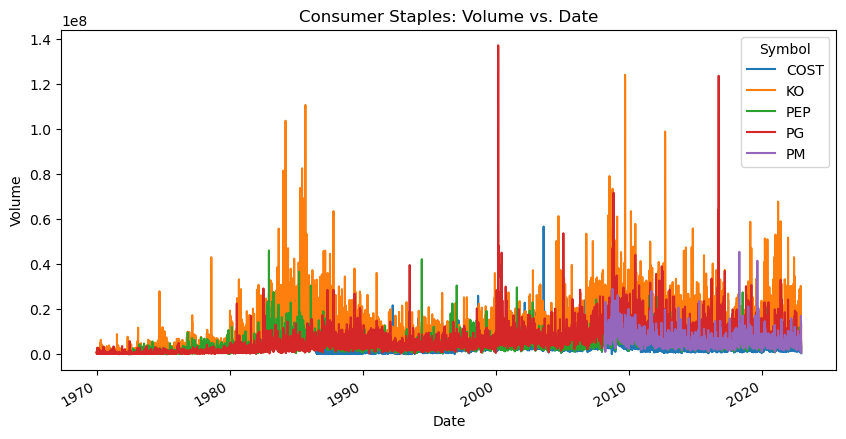

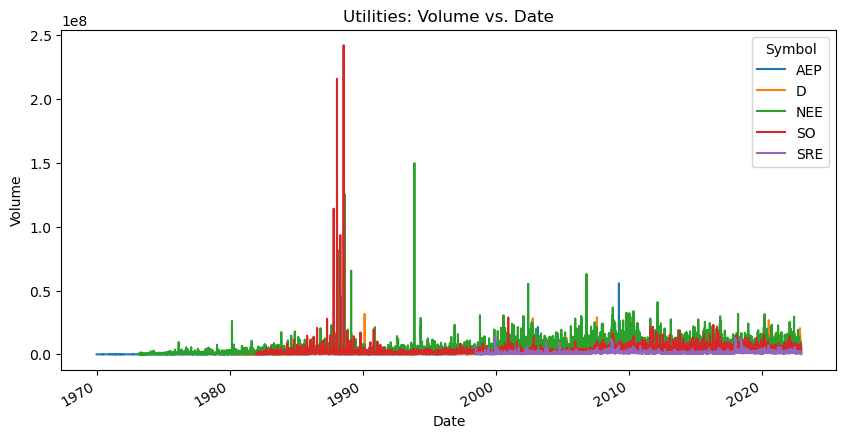

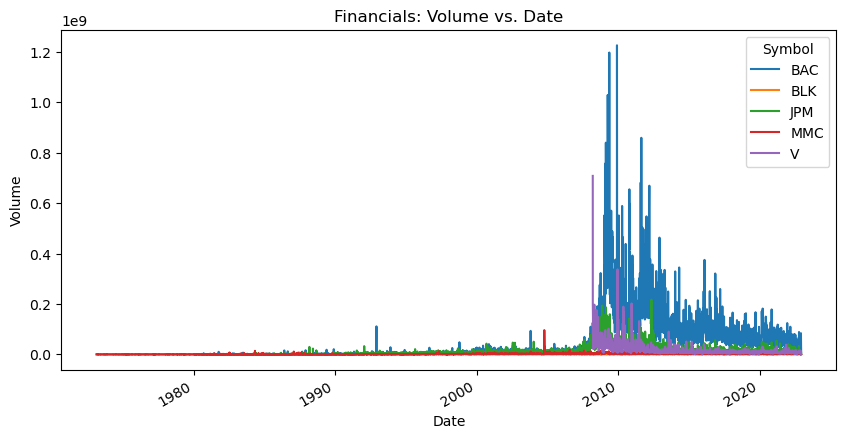

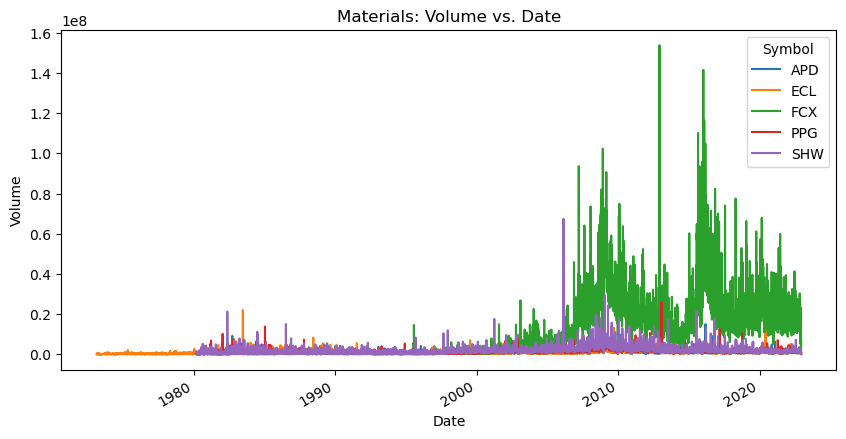

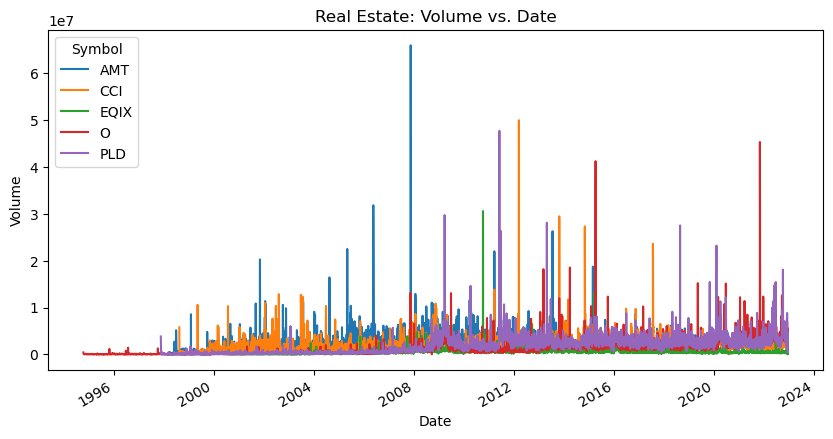

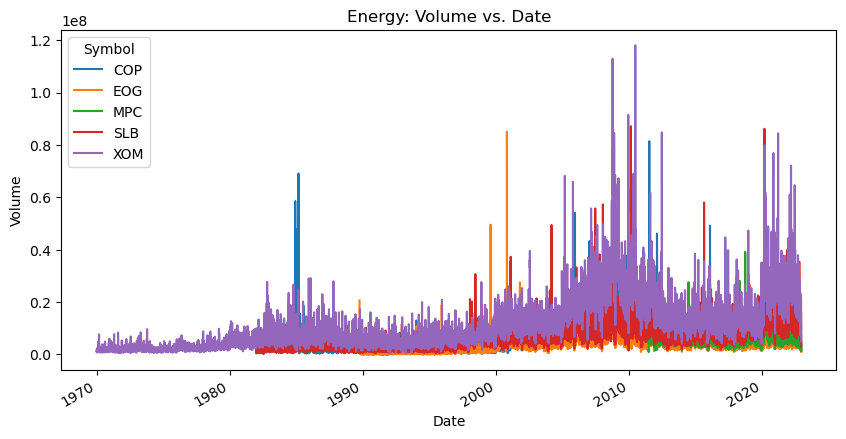

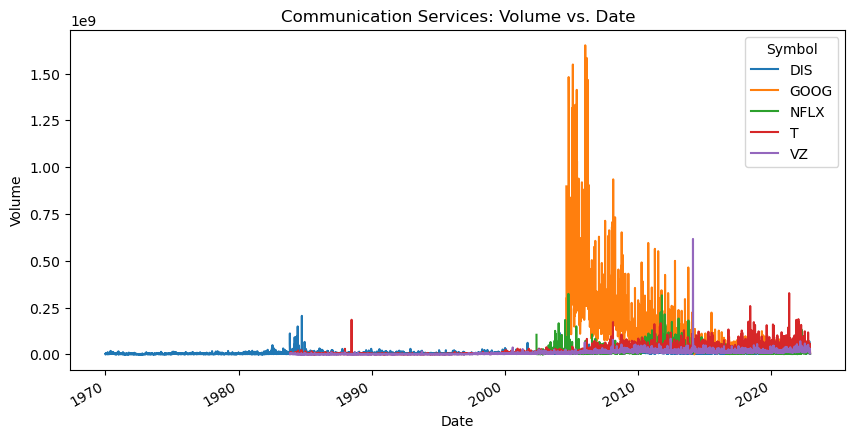

In [10]:
# Generate a plot for the top five companies in each sector
for sector in top_data['Sector'].unique():
    
    # Filter the data for the current sector
    sector_data = top_data[top_data['Sector'] == sector]
    
    # Reshape the data for plotting purposes
    sec_as_row = sector_data.pivot(index = 'Date', columns = 'Symbol', values = 'Volume')
    
    # Generate plot
    sec_as_row.plot(title = f'{sector}: Volume vs. Date', legend = True, xlabel = 'Date', ylabel = 'Volume', figsize = (10, 5))

Above are 11 line plots of volume traded vs. date for the the top five companies (by weight) in each sector.

ANALYZE CORRELATIONS

In [11]:
# Lengths of moving averages to calculate
moving_averages = [10, 20, 50, 200]

# Different spans of moving average
for ma in moving_averages:

    # For each security
    for security in top_data['Security'].unique():
        
        # Filter the data for the current company
        security_data = top_data[top_data['Security'] == security]
        
        # Calculate moving average and add column
        top_data[f'{ma}-Day Moving Average'] = top_data['Adjusted Close'].rolling(ma).mean()
    
# Print last 5 rows
top_data.tail()

,Symbol,Security,Sector,Industry,Weight,Date,Open,High,Low,Close,Adjusted Close,Volume,10-Day Moving Average,20-Day Moving Average,50-Day Moving Average,200-Day Moving Average
518500,VZ,Verizon,Communication Services,Integrated Telecommunication Services,0.457305,2022-12-06,36.990002,37.070000,36.630001,36.889999,36.889999,26293700.0,38.3170,38.23500,37.580422,44.926802
518501,VZ,Verizon,Communication Services,Integrated Telecommunication Services,0.457305,2022-12-07,36.740002,37.310001,36.669998,37.169998,37.169998,23065900.0,38.1140,38.20000,37.558913,44.854061
518502,VZ,Verizon,Communication Services,Integrated Telecommunication Services,0.457305,2022-12-08,37.110001,37.240002,36.869999,37.099998,37.099998,19549100.0,37.9320,38.17400,37.526170,44.783320
518503,VZ,Verizon,Communication Services,Integrated Telecommunication Services,0.457305,2022-12-09,37.209999,37.630001,36.959999,37.400002,37.400002,20669100.0,37.7700,38.11800,37.514178,44.718013
518504,VZ,Verizon,Communication Services,Integrated Telecommunication Services,0.457305,2022-12-12,37.689999,37.730000,37.279999,37.615002,37.615002,4698435.0,37.7075,38.08375,37.519664,44.646441


In [15]:
# Insert a new column to contain the daily return
top_data['Daily Return'] = top_data['Adjusted Close'].pct_change()

# Print the last five rows of the data frame
top_data.tail()

,Symbol,Security,Sector,Industry,Weight,Date,Open,High,Low,Close,Adjusted Close,Volume,10-Day Moving Average,20-Day Moving Average,50-Day Moving Average,200-Day Moving Average,Daily Return
518500,VZ,Verizon,Communication Services,Integrated Telecommunication Services,0.457305,2022-12-06,36.990002,37.070000,36.630001,36.889999,36.889999,26293700.0,38.3170,38.23500,37.580422,44.926802,-0.004856
518501,VZ,Verizon,Communication Services,Integrated Telecommunication Services,0.457305,2022-12-07,36.740002,37.310001,36.669998,37.169998,37.169998,23065900.0,38.1140,38.20000,37.558913,44.854061,0.007590
518502,VZ,Verizon,Communication Services,Integrated Telecommunication Services,0.457305,2022-12-08,37.110001,37.240002,36.869999,37.099998,37.099998,19549100.0,37.9320,38.17400,37.526170,44.783320,-0.001883
518503,VZ,Verizon,Communication Services,Integrated Telecommunication Services,0.457305,2022-12-09,37.209999,37.630001,36.959999,37.400002,37.400002,20669100.0,37.7700,38.11800,37.514178,44.718013,0.008086
518504,VZ,Verizon,Communication Services,Integrated Telecommunication Services,0.457305,2022-12-12,37.689999,37.730000,37.279999,37.615002,37.615002,4698435.0,37.7075,38.08375,37.519664,44.646441,0.005749


## Data Analysis, Hypothesis Testing, and Machine Learning

## Insights